<a href="https://colab.research.google.com/github/noamZigler/part-2--Technical-Analysis/blob/main/part2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install ccxt pandas
import ccxt
import pandas as pd
import requests
import time
import json
import datetime
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.12
    Uninstalling aiohttp-3.11.12:
      Successfully uninstalled aiohttp-3.11.12


In [3]:

def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')

In [25]:

exchange = ccxt.binanceus()  # Data only from binanceUS
symbol = "BTC/USDT"
Interval = "30m"
start = int(datetime.datetime(2023, 1, 1).timestamp() * 1000)
end = int(datetime.datetime(2024, 1, 1).timestamp() * 1000)


ohlcv_data = []
while start < end:
    data = exchange.fetch_ohlcv(symbol, Interval, since=start,limit=1000)
    if not data:
        break
    ohlcv_data.extend(data)
    start = data[-1][0] + 1

df = pd.DataFrame(ohlcv_data, columns=["time", "open", "high", "low", "close", "volume"])
df["time"] = pd.to_datetime(df["time"], unit="ms")
df


,time,open,high,low,close,volume
0,2023-01-01 00:00:00,16524.41,16532.52,16501.72,16532.46,7.324332
1,2023-01-01 00:30:00,16533.00,16533.00,16500.63,16526.09,9.486023
2,2023-01-01 01:00:00,16528.29,16532.36,16518.79,16524.50,5.659982
3,2023-01-01 01:30:00,16524.01,16546.99,16524.01,16546.99,5.944290
4,2023-01-01 02:00:00,16537.70,16554.60,16529.80,16544.06,7.605700
...,...,...,...,...,...,...
17995,2024-01-11 04:30:00,46469.06,46510.65,46402.10,46407.95,1.786950
17996,2024-01-11 05:00:00,46407.95,46410.24,46266.63,46299.02,4.044840
17997,2024-01-11 05:30:00,46320.00,46340.67,45963.73,46120.26,11.170300
17998,2024-01-11 06:00:00,46075.39,46115.57,45687.06,45792.54,8.357120


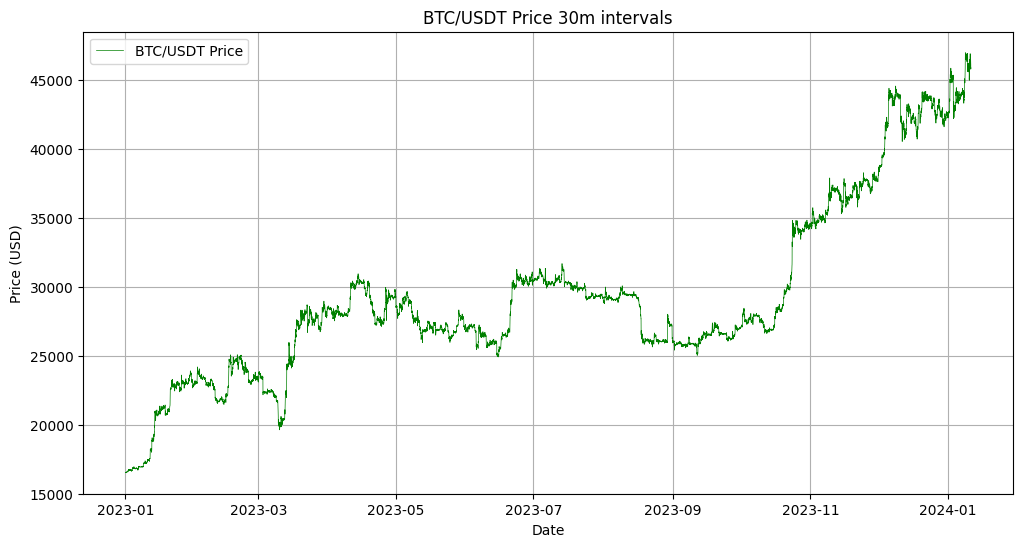

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["close"], label="BTC/USDT Price", color="green", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("BTC/USDT Price 30m intervals")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def MACD(data, short_ema=23, long_ema=50, signal_ema=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_ema, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_ema, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    return data['MACD']
def Stochastic_MACD(data,stoch_period):
    data['Lowest_MACD'] = data.rolling(window=stoch_period).min()
    data['Highest_MACD'] = data.rolling(window=stoch_period).max()
    data['Stoch_K'] = 100 * ((data - data['Lowest_MACD']) / (data['Highest_MACD'] - data['Lowest_MACD']))
    return data['Stoch_K']

def stc_indicator(data, short_ema=23, long_ema=50, stoch_period=10, smooth_period=10):
    data['MACD']=MACD(data,short_ema=short_ema, long_ema=long_ema)
    data['Stoch_K']=Stochastic_MACD(data['MACD'],stoch_period)
    # Smooth the Stochastic %K using EMA
    data['STC'] = data['Stoch_K'].ewm(span=smooth_period, adjust=False).mean()
    return data['STC']


#  ATR (Average True Range)
def ATR(data, period=14):
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=period).mean()
    return data

def ut_bot_indicator(data, atr_multiplier=1.5, atr_period=14, ma_period=50):
    data = ATR(data, atr_period)
    # Compute Moving Average
    data['MA'] = data['Close'].rolling(window=ma_period).mean()

    data['UT_Bot_Upper'] = data['MA'] + (data['ATR'] * atr_multiplier)
    data['UT_Bot_Lower'] = data['MA'] - (data['ATR'] * atr_multiplier)
    data['Buy_Signal'] = (data['Close'] > data['UT_Bot']) & (data['Close'].shift(1) <= data['UT_Bot'].shift(1))
    data['Sell_Signal'] = (data['Close'] < data['UT_Bot']) & (data['Close'].shift(1) >= data['UT_Bot'].shift(1))
    return data

In [31]:
# Implementing the strategy
from strategies import BaseStrategy
from models import ActionType, Position, PositionType, StrategySignal
from abc import ABC, abstractmethod
from typing import Tuple

In [ ]:
class UTSTCStrategy(BaseStrategy):
    def __init__(self, ut_period: int = 10, stc_period: int = 10, sl_rate: float = None, tp_rate: float = None) -> None:
        super().__init__(sl_rate, tp_rate)
        self.ut_period = ut_period
        self.stc_period = stc_period

    def calc_signal(self, data: pd.DataFrame) -> pd.Series:
        #to put correct values
        data['UT_SMA'] = ut_bot_indicator(data, atr_multiplier=1.5, atr_period=14, ma_period=50)
        data['UT_signal'] = data['Close'] > data['UT_SMA']

        #to put correct values
        data['STC'] = stc_indicator(data, short_ema=23, long_ema=50, stoch_period=10, smooth_period=10)
        data['STC_signal'] = data['STC'] > 70 # change the threshold



        # Loop over each row to set trading signals based on UT and STC conditions.
        for i in range(len(data)):
            # Both indicators bullish: entry long.
            if data['UT_signal'].iloc[i] and data['STC'].iloc[i] > 75:
                data.iloc[i, data.columns.get_loc('strategy_signal')] = StrategySignal.ENTER_LONG
            # Both indicators bearish: entry short.
            elif (not data['UT_signal'].iloc[i]) and data['STC'].iloc[i] < 25:
                data.iloc[i, data.columns.get_loc('strategy_signal')] = StrategySignal.ENTER_SHORT
            else:
                data.iloc[i, data.columns.get_loc('strategy_signal')] = StrategySignal.DO_NOTHING

        # Ensure exit signals at the last row.
        if data['UT_signal'].iloc[-1]:
            data.iloc[-1, data.columns.get_loc('strategy_signal')] = StrategySignal.CLOSE_LONG
        else:
            data.iloc[-1, data.columns.get_loc('strategy_signal')] = StrategySignal.CLOSE_SHORT

        return data['strategy_signal']

